In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

In [2]:
from utils import visualize_annotations_from_csv, QRDataset2, visualize_batch , QRDataset3

In [3]:
csv_file = r'C:\Users\ovill\OneDrive\Escritorio\QR SSD\sinteticos\annotations.csv'
image_folder = r'C:\Users\ovill\OneDrive\Escritorio\QR SSD\sinteticos'

train_dataset = QRDataset3(
    csv_path=csv_file,
    image_dir=image_folder,
    split='train',
    im_size=300
)

Agrupando anotaciones del CSV...
[✓] 8000 imágenes indexadas (solo CSV) desde C:\Users\ovill\OneDrive\Escritorio\QR SSD\sinteticos\annotations.csv


In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    collate_fn=lambda batch: tuple(zip(*batch)),
    shuffle=True,
    num_workers=4, 
    pin_memory=True
)

In [5]:
def ssd_collate(batch):
    images = torch.stack([b[0] for b in batch], dim=0)
    targets = [b[1] for b in batch]
    filenames = [b[2] for b in batch]
    return images, targets, filenames

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=ssd_collate
)


In [6]:
ims, targets, _ = next(iter(train_loader))

# Tamaño real de la imagen tras augmentations
H, W = ims[0].shape[-2:]

# Mostrar primeras cajas del primer ejemplo
print("GT (raw):", targets[0]["boxes"][:5])  # normalmente en píxeles
print("H, W     :", H, W)


GT (raw): tensor([[0.4895, 0.8574, 0.6494, 0.9540]])
H, W     : 300 300


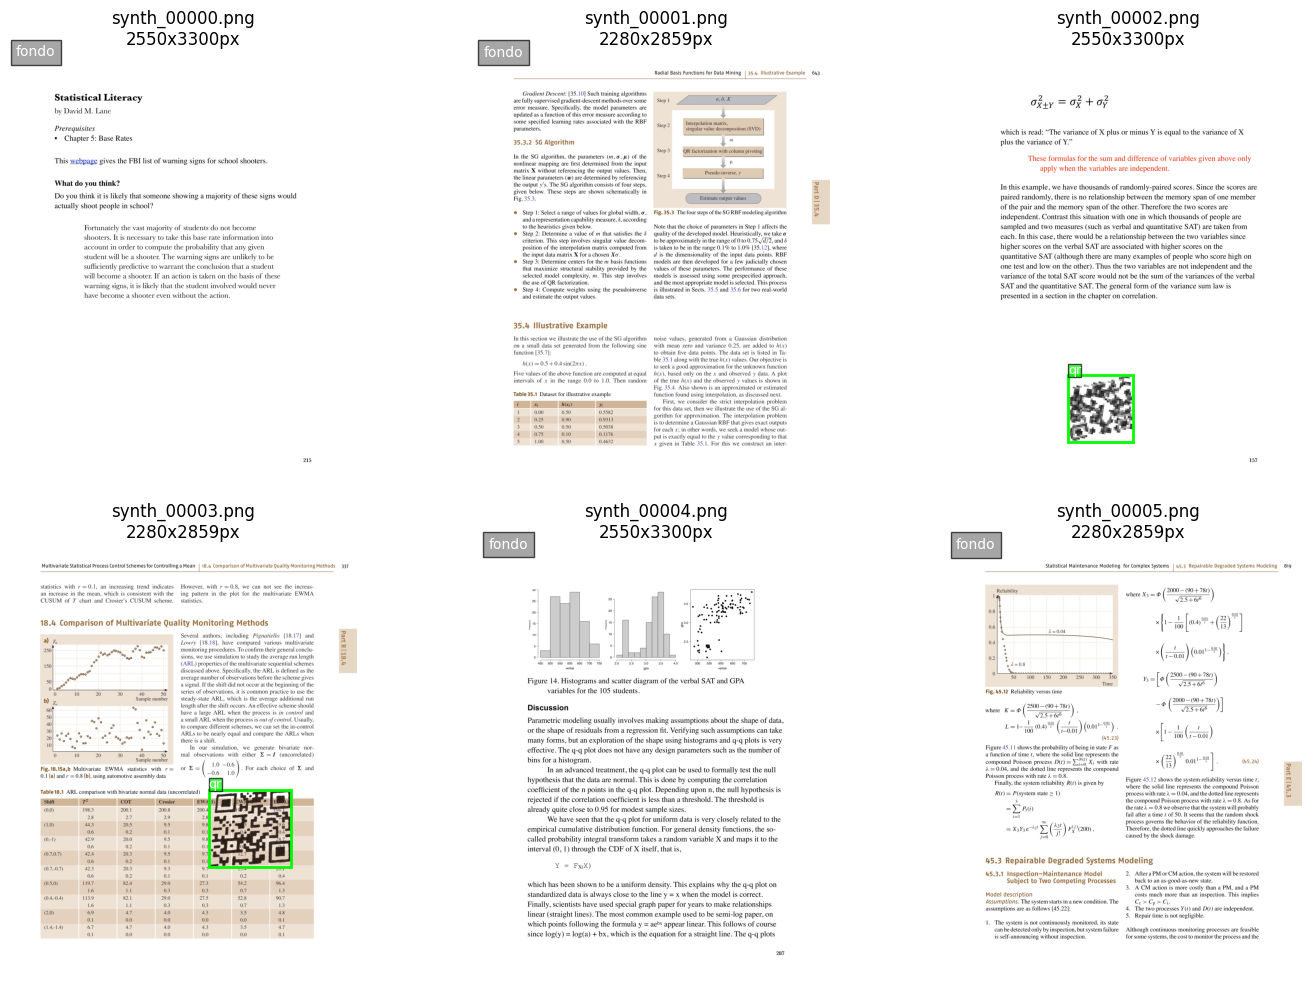

In [7]:
visualize_annotations_from_csv(csv_file ,image_folder , num_images_to_show=6 )

 El dataset no tiene atributos 'imagenet_mean' ni 'imagenet_std'. Usando [0.0], [1.0].


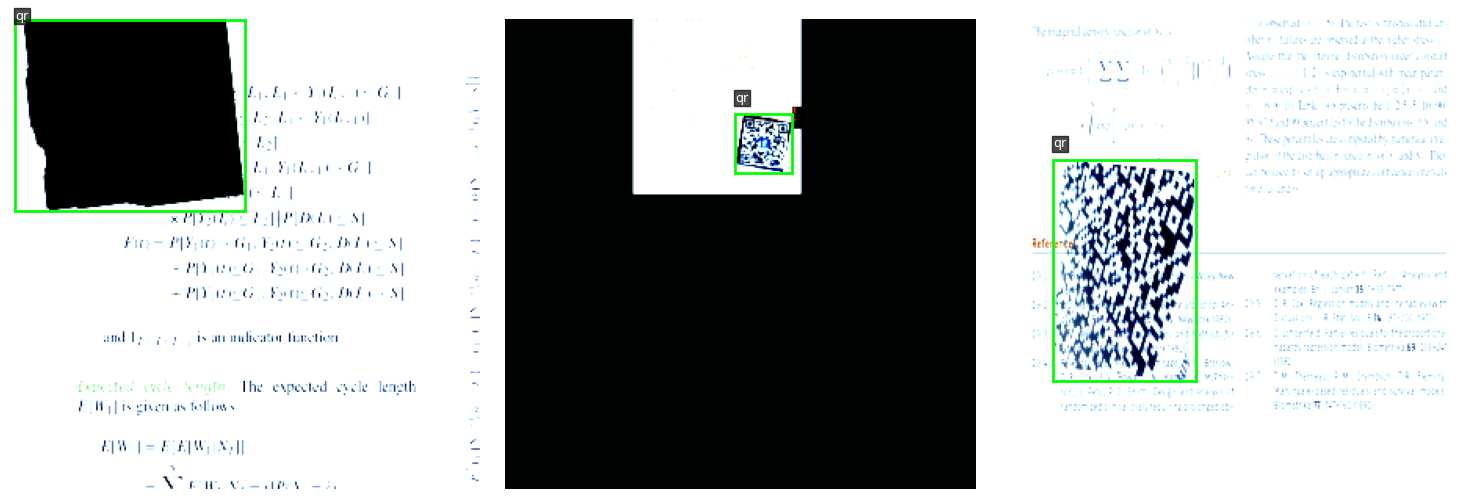

In [8]:
visualize_batch(train_loader , train_dataset , num_images=3)

### SSD

In [9]:
import torch.nn as nn
import torch
import math
import torchvision


def get_iou(boxes1, boxes2):
    r"""
    IOU between two sets of boxes
    :param boxes1: (Tensor of shape N x 4)
    :param boxes2: (Tensor of shape M x 4)
    :return: IOU matrix of shape N x M
    """

    # Area of boxes (x2-x1)*(y2-y1)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # (N,)
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # (M,)

    # Get top left x1,y1 coordinate
    x_left = torch.max(boxes1[:, None, 0], boxes2[:, 0])  # (N, M)
    y_top = torch.max(boxes1[:, None, 1], boxes2[:, 1])  # (N, M)

    # Get bottom right x2,y2 coordinate
    x_right = torch.min(boxes1[:, None, 2], boxes2[:, 2])  # (N, M)
    y_bottom = torch.min(boxes1[:, None, 3], boxes2[:, 3])  # (N, M)

    intersection_area = ((x_right - x_left).clamp(min=0) *
                         (y_bottom - y_top).clamp(min=0))  # (N, M)
    union = area1[:, None] + area2 - intersection_area  # (N, M)
    iou = intersection_area / union  # (N, M)
    return iou


def boxes_to_transformation_targets(ground_truth_boxes,
                                    default_boxes,
                                    weights=(10., 10., 5., 5.)):
    r"""
    Method to compute targets for each default_boxes.
    Assumes boxes are in x1y1x2y2 format.
    We first convert boxes to cx,cy,w,h format and then
    compute targets based on following formulation
    target_dx = (gt_cx - default_boxes_cx) / default_boxes_w
    target_dy = (gt_cy - default_boxes_cy) / default_boxes_h
    target_dw = log(gt_w / default_boxes_w)
    target_dh = log(gt_h / default_boxes_h)
    :param ground_truth_boxes: (Tensor of shape N x 4)
    :param default_boxes: (Tensor of shape N x 4)
    :param weights: Tuple[float] -> (wx, wy, ww, wh)
    :return: regression_targets: (Tensor of shape N x 4)
    """
    # # Get center_x,center_y,w,h from x1,y1,x2,y2 for default_boxes
    widths = default_boxes[:, 2] - default_boxes[:, 0]
    heights = default_boxes[:, 3] - default_boxes[:, 1]
    center_x = default_boxes[:, 0] + 0.5 * widths
    center_y = default_boxes[:, 1] + 0.5 * heights

    # # Get center_x,center_y,w,h from x1,y1,x2,y2 for gt boxes
    gt_widths = (ground_truth_boxes[:, 2] - ground_truth_boxes[:, 0])
    gt_heights = ground_truth_boxes[:, 3] - ground_truth_boxes[:, 1]
    gt_center_x = ground_truth_boxes[:, 0] + 0.5 * gt_widths
    gt_center_y = ground_truth_boxes[:, 1] + 0.5 * gt_heights

    # Use formulation to compute all targets
    targets_dx = weights[0] * (gt_center_x - center_x) / widths
    targets_dy = weights[1] * (gt_center_y - center_y) / heights
    targets_dw = weights[2] * torch.log(gt_widths / widths)
    targets_dh = weights[3] * torch.log(gt_heights / heights)
    regression_targets = torch.stack((targets_dx,
                                      targets_dy,
                                      targets_dw,
                                      targets_dh), dim=1)
    return regression_targets


def apply_regression_pred_to_default_boxes(box_transform_pred,
                                           default_boxes,
                                           weights=(10., 10., 5., 5.)):
    r"""
    Method to transform default_boxes based on transformation parameter
    prediction.
    Assumes boxes are in x1y1x2y2 format
    :param box_transform_pred: (Tensor of shape N x 4)
    :param default_boxes: (Tensor of shape N x 4)
    :param weights: Tuple[float] -> (wx, wy, ww, wh)
    :return: pred_boxes: (Tensor of shape N x 4)
    """

    # Get cx, cy, w, h from x1,y1,x2,y2
    w = default_boxes[:, 2] - default_boxes[:, 0]
    h = default_boxes[:, 3] - default_boxes[:, 1]
    center_x = default_boxes[:, 0] + 0.5 * w
    center_y = default_boxes[:, 1] + 0.5 * h

    dx = box_transform_pred[..., 0] / weights[0]
    dy = box_transform_pred[..., 1] / weights[1]
    dw = box_transform_pred[..., 2] / weights[2]
    dh = box_transform_pred[..., 3] / weights[3]
    # dh -> (num_default_boxes)

    pred_center_x = dx * w + center_x
    pred_center_y = dy * h + center_y
    pred_w = torch.exp(dw) * w
    pred_h = torch.exp(dh) * h
    # pred_center_x -> (num_default_boxes, 4)

    pred_box_x1 = pred_center_x - 0.5 * pred_w
    pred_box_y1 = pred_center_y - 0.5 * pred_h
    pred_box_x2 = pred_center_x + 0.5 * pred_w
    pred_box_y2 = pred_center_y + 0.5 * pred_h

    pred_boxes = torch.stack((
        pred_box_x1,
        pred_box_y1,
        pred_box_x2,
        pred_box_y2),
        dim=-1)
    return pred_boxes


def generate_default_boxes(feat, aspect_ratios, scales):
    r"""
    Method to generate default_boxes for all feature maps the image
    :param feat: List[(Tensor of shape B x C x Feat_H x Feat x W)]
    :param aspect_ratios: List[List[float]] aspect ratios for each feature map
    :param scales: List[float] scales for each feature map
    :return: default_boxes : List[(Tensor of shape N x 4)] default_boxes over all
            feature maps aggregated for each batch image
    """

    # List to store default boxes for all feature maps
    default_boxes = []
    for k in range(len(feat)):
        # We first add the aspect ratio 1 and scale (sqrt(scale[k])*sqrt(scale[k+1])
        s_prime_k = math.sqrt(scales[k] * scales[k + 1])
        wh_pairs = [[s_prime_k, s_prime_k]]

        # Adding all possible w,h pairs according to
        # aspect ratio of the feature map k
        for ar in aspect_ratios[k]:
            sq_ar = math.sqrt(ar)
            w = scales[k] * sq_ar
            h = scales[k] / sq_ar

            wh_pairs.extend([[w, h]])

        feat_h, feat_w = feat[k].shape[-2:]

        # These shifts will be the centre of each of the default boxes
        shifts_x = ((torch.arange(0, feat_w) + 0.5) / feat_w).to(torch.float32)
        shifts_y = ((torch.arange(0, feat_h) + 0.5) / feat_h).to(torch.float32)
        shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
        shift_x = shift_x.reshape(-1)
        shift_y = shift_y.reshape(-1)

        # Duplicate these shifts for as
        # many boxes(aspect ratios)
        # per position we have
        shifts = torch.stack((shift_x, shift_y) * len(wh_pairs), dim=-1).reshape(-1, 2)
        # shifts for first feature map will be (5776 x 2)

        wh_pairs = torch.as_tensor(wh_pairs)

        # Repeat the wh pairs for all positions in feature map
        wh_pairs = wh_pairs.repeat((feat_h * feat_w), 1)
        # wh_pairs for first feature map will be (5776 x 2)

        # Concat the shifts(cx cy) and wh values for all positions
        default_box = torch.cat((shifts, wh_pairs), dim=1)
        # default box for feat_1 -> (5776, 4)
        # default box for feat_2 -> (2166, 4)
        # default box for feat_3 -> (600, 4)
        # default box for feat_4 -> (150, 4)
        # default box for feat_5 -> (36, 4)
        # default box for feat_6 -> (4, 4)

        default_boxes.append(default_box)
    default_boxes = torch.cat(default_boxes, dim=0)
    # default_boxes -> (8732, 4)

    # We now duplicate these default boxes
    # for all images in the batch
    # and also convert cx,cy,w,h format of
    # default boxes to x1,y1,x2,y2
    dboxes = []
    for _ in range(feat[0].size(0)):
        dboxes_in_image = default_boxes
        # x1 = cx - 0.5 * width
        # y1 = cy - 0.5 * height
        # x2 = cx + 0.5 * width
        # y2 = cy + 0.5 * height
        dboxes_in_image = torch.cat(
            [
                (dboxes_in_image[:, :2] - 0.5 * dboxes_in_image[:, 2:]),
                (dboxes_in_image[:, :2] + 0.5 * dboxes_in_image[:, 2:]),
            ],
            -1,
        )
        dboxes.append(dboxes_in_image.to(feat[0].device))
    return dboxes

def generate_default_boxes(feat, aspect_ratios, scales):
    """
    Versión GPU-safe: construye TODO en el device de los feature maps.
    Retorna lista de (8732, 4) tensores en x1y1x2y2, uno por imagen del batch.
    """
    import math
    device = feat[0].device  # usar el device de las features

    dboxes_all = []
    for k in range(len(feat)):
        # s'_k y pares (w,h) para ARs en GPU
        s_prime_k = math.sqrt(scales[k] * scales[k + 1])
        wh_pairs = [[s_prime_k, s_prime_k]]
        for ar in aspect_ratios[k]:
            sq_ar = math.sqrt(ar)
            wh_pairs.append([scales[k] * sq_ar, scales[k] / sq_ar])
        wh_pairs = torch.tensor(wh_pairs, device=device, dtype=torch.float32)  # (A,2)

        # Hk, Wk del mapa k
        Hk, Wk = feat[k].shape[-2:]

        # centros normalizados (cx,cy) en GPU
        shifts_x = (torch.arange(Wk, device=device, dtype=torch.float32) + 0.5) / Wk
        shifts_y = (torch.arange(Hk, device=device, dtype=torch.float32) + 0.5) / Hk
        yy, xx = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
        centers = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)         # (Hk*Wk,2)

        # repetir por cada anchor (aspect ratio)
        centers = centers.repeat_interleave(wh_pairs.size(0), dim=0)            # (Hk*Wk*A,2)
        wh      = wh_pairs.repeat(Hk * Wk, 1)                                   # (Hk*Wk*A,2)

        # cxcywh -> x1y1x2y2
        x1y1 = centers - 0.5 * wh
        x2y2 = centers + 0.5 * wh
        x1y1x2y2 = torch.cat([x1y1, x2y2], dim=1)                               # (Nk,4)
        dboxes_all.append(x1y1x2y2)

    # concatenar todos los mapas (8732,4) en device
    default_boxes_single = torch.cat(dboxes_all, dim=0)

    # duplicar por tamaño de batch (comparten mismos anchors)
    B = feat[0].size(0)
    default_boxes = [default_boxes_single] * B
    return default_boxes



class SSD(nn.Module):
    r"""
    Main Class for SSD. Does the following steps
    to generate detections/losses.
    During initialization
    1. Load VGG Imagenet pretrained model
    2. Extract Backbone from VGG and add extra conv layers
    3. Add class prediction and bbox transformation prediction layers
    4. Initialize all conv2d layers

    During Forward Pass
    1. Get conv4_3 output
    2. Normalize and scale conv4_3 output (feat_output_1)
    3. Pass the unscaled conv4_3 to conv5_3 layers and conv layers
        replacing fc6 and fc7 of vgg (feat_output_2)
    4. Pass the conv_fc7 output to extra conv layers (feat_output_3-6)
    5. Get the classification and regression predictions for all 6 feature maps
    6. Generate default_boxes for all these feature maps(8732 x 4)
    7a. If in training assign targets for these default_boxes and
        compute localization and classification losses
    7b. If in inference mode, then do all pre-nms filtering, nms
        and then post nms filtering and return the detected boxes,
        their labels and their scores
    """
    def __init__(self, config, num_classes=21):
        super().__init__()
        self.aspect_ratios = config['aspect_ratios']

        self.scales = config['scales']
        self.scales.append(1.0)

        self.num_classes = num_classes
        self.iou_threshold = config['iou_threshold']
        self.low_score_threshold = config['low_score_threshold']
        self.neg_pos_ratio = config['neg_pos_ratio']
        self.pre_nms_topK = config['pre_nms_topK']
        self.nms_threshold = config['nms_threshold']
        self.detections_per_img = config['detections_per_img']

        # Load imagenet pretrained vgg network
        backbone = torchvision.models.vgg16(
            weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1
        )

        # Get all max pool indexes to determine different stages
        max_pool_pos = [idx for idx, layer in enumerate(list(backbone.features))
                        if isinstance(layer, nn.MaxPool2d)]
        max_pool_stage_3_pos = max_pool_pos[-3]  # for vgg16 this would be 16
        max_pool_stage_4_pos = max_pool_pos[-2]  # for vgg16 this would be 23

        backbone.features[max_pool_stage_3_pos].ceil_mode = True
        # otherwise vgg conv4_3 output will be 37x37
        self.features = nn.Sequential(*backbone.features[:max_pool_stage_4_pos])
        self.scale_weight = nn.Parameter(torch.ones(512) * 20)

        ###################################
        # Conv5_3 + Conv for fc6 and fc 7 #
        ###################################
        # Conv modules replacing fc6 and fc7
        # Ideally we would copy the weights
        # but here we are just adding new layers
        # and not copying fc6 and fc7 weights by
        # subsampling
        fcs = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3,
                      padding=6, dilation=6),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.conv5_3_fc = nn.Sequential(
            *backbone.features[max_pool_stage_4_pos:-1],
            fcs,
        )

        ##########################
        # Additional Conv Layers #
        ##########################
        # Modules to take from 19x19 to 10x10
        self.conv8_2 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1,
                      stride=2),
            nn.ReLU(inplace=True)
        )

        # Modules to take from 10x10 to 5x5
        self.conv9_2 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1,
                      stride=2),
            nn.ReLU(inplace=True)
        )

        # Modules to take from 5x5 to 3x3
        self.conv10_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True)
        )

        # Modules to take from 3x3 to 1x1
        self.conv11_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True)
        )

        # Must match conv4_3, fcs, conv8_2, conv9_2, conv10_2, conv11_2
        out_channels = [512, 1024, 512, 256, 256, 256]

        #####################
        # Prediction Layers #
        #####################
        self.cls_heads = nn.ModuleList()
        for channels, aspect_ratio in zip(out_channels, self.aspect_ratios):
            # extra 1 is added for scale of sqrt(sk*sk+1)
            self.cls_heads.append(nn.Conv2d(channels,
                                            self.num_classes * (len(aspect_ratio)+1),
                                            kernel_size=3,
                                            padding=1))

        self.bbox_reg_heads = nn.ModuleList()
        for channels, aspect_ratio in zip(out_channels, self.aspect_ratios):
            # extra 1 is added for scale of sqrt(sk*sk+1)
            self.bbox_reg_heads.append(nn.Conv2d(channels, 4 * (len(aspect_ratio)+1),
                                                 kernel_size=3,
                                                 padding=1))

        #############################
        # Conv Layer Initialization #
        #############################
        for layer in fcs.modules():
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.constant_(layer.bias, 0.0)

        for conv_module in [self.conv8_2, self.conv9_2, self.conv10_2, self.conv11_2]:
            for layer in conv_module.modules():
                if isinstance(layer, nn.Conv2d):
                    torch.nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        torch.nn.init.constant_(layer.bias, 0.0)

        for module in self.cls_heads:
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0.0)
        for module in self.bbox_reg_heads:
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0.0)

    def compute_loss(
            self,
            targets,
            cls_logits,
            bbox_regression,
            default_boxes,
            matched_idxs,
    ):
        # Counting all the foreground default_boxes for computing N in loss equation
        num_foreground = 0
        # BBox losses for all batch images(for foreground default_boxes)
        bbox_loss = []
        # classification targets for all batch images(for ALL default_boxes)
        cls_targets = []
        for (
            targets_per_image,
            bbox_regression_per_image,
            cls_logits_per_image,
            default_boxes_per_image,
            matched_idxs_per_image,
        ) in zip(targets, bbox_regression, cls_logits, default_boxes, matched_idxs):
            # Foreground default_boxes -> matched_idx >=0
            # Background default_boxes -> matched_idx = -1
            fg_idxs_per_image = torch.where(matched_idxs_per_image >= 0)[0]
            foreground_matched_idxs_per_image = matched_idxs_per_image[
                fg_idxs_per_image
            ]
            num_foreground += foreground_matched_idxs_per_image.numel()

            # Get foreground default_boxes and their transformation predictions
            matched_gt_boxes_per_image = targets_per_image["boxes"][
                foreground_matched_idxs_per_image
            ]
            bbox_regression_per_image = bbox_regression_per_image[fg_idxs_per_image, :]
            default_boxes_per_image = default_boxes_per_image[fg_idxs_per_image, :]
            target_regression = boxes_to_transformation_targets(
                matched_gt_boxes_per_image,
                default_boxes_per_image)

            bbox_loss.append(
                torch.nn.functional.smooth_l1_loss(bbox_regression_per_image,
                                                   target_regression,
                                                   reduction='sum')
            )

            # Get classification target for ALL default_boxes
            # For all default_boxes set it as 0 first
            # Then set foreground default_boxes target as label
            # of assigned gt box
            gt_classes_target = torch.zeros(
                (cls_logits_per_image.size(0),),
                dtype=targets_per_image["labels"].dtype,
                device=targets_per_image["labels"].device,
            )
            gt_classes_target[fg_idxs_per_image] = targets_per_image["labels"][
                foreground_matched_idxs_per_image
            ]
            cls_targets.append(gt_classes_target)

        # Aggregated bbox loss and classification targets
        # for all batch images
        bbox_loss = torch.stack(bbox_loss)
        cls_targets = torch.stack(cls_targets)  # (B, 8732)

        # Calculate classification loss for ALL default_boxes
        num_classes = cls_logits.size(-1)
        cls_loss = torch.nn.functional.cross_entropy(cls_logits.view(-1, num_classes),
                                                     cls_targets.view(-1),
                                                     reduction="none").view(
            cls_targets.size()
        )

        # Hard Negative Mining
        foreground_idxs = cls_targets > 0
        # We will sample total of 3 x (number of fg default_boxes)
        # background default_boxes
        num_negative = self.neg_pos_ratio * foreground_idxs.sum(1, keepdim=True)

        # As of now cls_loss is for ALL default_boxes
        negative_loss = cls_loss.clone()
        # We want to ensure that after sorting based on loss value,
        # foreground default_boxes are never picked when choosing topK
        # highest loss indexes
        negative_loss[foreground_idxs] = -float("inf")
        values, idx = negative_loss.sort(1, descending=True)
        # Fetch those indexes which have in topK(K=num_negative) losses
        background_idxs = idx.sort(1)[1] < num_negative
        N = max(1, num_foreground)
        return {
            "bbox_regression": bbox_loss.sum() / N,
            "classification": (cls_loss[foreground_idxs].sum() +
                               cls_loss[background_idxs].sum()) / N,
        }

    def forward(self, x, targets=None):
        # Call everything till conv4_3 layers first
        conv_4_3_out = self.features(x)

        # Scale conv4_3 output using learnt norm scale
        conv_4_3_out_scaled = (self.scale_weight.view(1, -1, 1, 1) *
                               torch.nn.functional.normalize(conv_4_3_out))

        # Call conv5_3 with non_scaled conv_3 and also
        # Call additional conv layers
        conv_5_3_fc_out = self.conv5_3_fc(conv_4_3_out)
        conv8_2_out = self.conv8_2(conv_5_3_fc_out)
        conv9_2_out = self.conv9_2(conv8_2_out)
        conv10_2_out = self.conv10_2(conv9_2_out)
        conv11_2_out = self.conv11_2(conv10_2_out)

        # Feature maps for predictions
        outputs = [
            conv_4_3_out_scaled,  # 38 x 38
            conv_5_3_fc_out,  # 19 x 19
            conv8_2_out,  # 10 x 10
            conv9_2_out,  # 5 x 5
            conv10_2_out,  # 3 x 3
            conv11_2_out,   # 1 x 1
        ]

        # Classification and bbox regression for all feature maps
        cls_logits = []
        bbox_reg_deltas = []
        for i, features in enumerate(outputs):
            cls_feat_i = self.cls_heads[i](features)
            bbox_reg_feat_i = self.bbox_reg_heads[i](features)

            # Cls output from (B, A * num_classes, H, W) to (B, HWA, num_classes).
            N, _, H, W = cls_feat_i.shape
            cls_feat_i = cls_feat_i.view(N, -1, self.num_classes, H, W)
            # (B, A, num_classes, H, W)
            cls_feat_i = cls_feat_i.permute(0, 3, 4, 1, 2)  # (B, H, W, A, num_classes)
            cls_feat_i = cls_feat_i.reshape(N, -1, self.num_classes)
            # (B, HWA, num_classes)
            cls_logits.append(cls_feat_i)

            # Permute bbox reg output from (B, A * 4, H, W) to (B, HWA, 4).
            N, _, H, W = bbox_reg_feat_i.shape
            bbox_reg_feat_i = bbox_reg_feat_i.view(N, -1, 4, H, W)  # (B, A, 4, H, W)
            bbox_reg_feat_i = bbox_reg_feat_i.permute(0, 3, 4, 1, 2)  # (B, H, W, A, 4)
            bbox_reg_feat_i = bbox_reg_feat_i.reshape(N, -1, 4)  # Size=(B, HWA, 4)
            bbox_reg_deltas.append(bbox_reg_feat_i)

        # Concat cls logits and bbox regression predictions for all feature maps
        cls_logits = torch.cat(cls_logits, dim=1)  # (B, 8732, num_classes)
        bbox_reg_deltas = torch.cat(bbox_reg_deltas, dim=1)  # (B, 8732, 4)

        # Generate default_boxes for all feature maps
        default_boxes = generate_default_boxes(outputs, self.aspect_ratios, self.scales)
        # default_boxes -> List[Tensor of shape 8732 x 4]
        # len(default_boxes) = Batch size

        losses = {}
        detections = []
        if self.training:
            # List to hold for each image, which default box
            # is assigned to with gt box if any
            # or unassigned(background)
            matched_idxs = []
            for default_boxes_per_image, targets_per_image in zip(default_boxes,
                                                                  targets):
                if targets_per_image["boxes"].numel() == 0:
                    matched_idxs.append(
                        torch.full(
                            (default_boxes_per_image.size(0),), -1,
                            dtype=torch.int64,
                            device=default_boxes_per_image.device
                        )
                    )
                    continue
                iou_matrix = get_iou(targets_per_image["boxes"],
                                     default_boxes_per_image)
                # For each default box find best ground truth box
                matched_vals, matches = iou_matrix.max(dim=0)
                # matches -> [8732]

                # Update index of match for all default_boxes which
                # have maximum iou with a gt box < low threshold
                # as -1
                # This allows selecting foreground boxes as match index >= 0
                below_low_threshold = matched_vals < self.iou_threshold
                matches[below_low_threshold] = -1

                # We want to also assign the best default box for every gt
                # as foreground
                # So first find the best default box for every gt
                _, highest_quality_pred_foreach_gt = iou_matrix.max(dim=1)
                # Update the best matching gt index for these best default_boxes
                # as 0, 1, 2, ...., len(gt)-1
                matches[highest_quality_pred_foreach_gt] = torch.arange(
                    highest_quality_pred_foreach_gt.size(0), dtype=torch.int64,
                    device=highest_quality_pred_foreach_gt.device
                )
                matched_idxs.append(matches)
            losses = self.compute_loss(targets, cls_logits, bbox_reg_deltas,
                                       default_boxes, matched_idxs)
        else:
            # For test time we do the following:
            # 1. Convert default_boxes to boxes using predicted bbox regression deltas
            # 2. Low score filtering
            # 3. Pre-NMS TopK filtering
            # 4. NMS
            # 5. Post NMS TopK Filtering
            cls_scores = torch.nn.functional.softmax(cls_logits, dim=-1)
            num_classes = cls_scores.size(-1)

            for bbox_deltas_i, cls_scores_i, default_boxes_i in zip(bbox_reg_deltas,
                                                                    cls_scores,
                                                                    default_boxes):
                boxes = apply_regression_pred_to_default_boxes(bbox_deltas_i,
                                                               default_boxes_i)
                # Ensure all values are between 0-1
                boxes.clamp_(min=0., max=1.)

                pred_boxes = []
                pred_scores = []
                pred_labels = []
                # Class wise filtering
                for label in range(1, num_classes):
                    score = cls_scores_i[:, label]

                    # Remove low scoring boxes of this class
                    keep_idxs = score > self.low_score_threshold
                    score = score[keep_idxs]
                    box = boxes[keep_idxs]

                    # keep only topk scoring predictions of this class
                    score, top_k_idxs = score.topk(min(self.pre_nms_topK, len(score)))
                    box = box[top_k_idxs]

                    pred_boxes.append(box)
                    pred_scores.append(score)
                    pred_labels.append(torch.full_like(score, fill_value=label,
                                                       dtype=torch.int64,
                                                       device=cls_scores.device))

                pred_boxes = torch.cat(pred_boxes, dim=0)
                pred_scores = torch.cat(pred_scores, dim=0)
                pred_labels = torch.cat(pred_labels, dim=0)

                # Class wise NMS
                keep_mask = torch.zeros_like(pred_scores, dtype=torch.bool)
                for class_id in torch.unique(pred_labels):
                    curr_indices = torch.where(pred_labels == class_id)[0]
                    curr_keep_idxs = torch.ops.torchvision.nms(pred_boxes[curr_indices],
                                                               pred_scores[curr_indices],
                                                               self.nms_threshold)
                    keep_mask[curr_indices[curr_keep_idxs]] = True
                keep_indices = torch.where(keep_mask)[0]
                post_nms_keep_indices = keep_indices[pred_scores[keep_indices].sort(
                    descending=True)[1]]
                keep = post_nms_keep_indices[:self.detections_per_img]
                pred_boxes, pred_scores, pred_labels = (pred_boxes[keep],
                                                        pred_scores[keep],
                                                        pred_labels[keep])

                detections.append(
                    {
                        "boxes": pred_boxes,
                        "scores": pred_scores,
                        "labels": pred_labels,
                    }
                )
        return losses, detections

In [10]:
config_qr = dict(
    aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2, 3]],
    scales=[0.1, 0.2, 0.375, 0.55, 0.725, 0.9],  # se añade dentro
    iou_threshold=0.5,       # foreground vs background
    low_score_threshold=0.05, # filtrar en inferencia
    neg_pos_ratio=3,         # hard-neg mining
    pre_nms_topK=200,
    nms_threshold=0.45,
    detections_per_img=200,
)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SSD(config=config_qr, num_classes=2).to(device).train()


In [12]:
first_param = next(model.parameters())
print("📦 Modelo cargado en:", first_param.device)

📦 Modelo cargado en: cuda:0


In [13]:
train_params = {
    "task_name": "ssd_qr",
    "seed": 1111,               # para reproducibilidad
    "acc_steps": 1,             # pasos de acumulación de gradientes
    "num_epochs": 10,           # número total de épocas
    "lr": 1e-4,                 # tasa de aprendizaje inicial
    "lr_steps": [8, 14, 18],    # milestones donde se reducirá el LR
    "log_steps": 100,           # cada cuántos steps mostrar pérdidas
    "infer_conf_threshold": 0.5,# umbral de confianza en inferencia
    "ckpt_name": r"C:\Users\ovill\OneDrive\Escritorio\QR SSD\Pesos\ssd_qr.pth",
}
checkpoint_dir = r"C:\Users\ovill\OneDrive\Escritorio\QR SSD\Pesos"

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=train_params["lr"],   
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=True
)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=train_params["lr_steps"], 
    gamma=0.5                             
)

scaler = torch.cuda.amp.GradScaler(enabled=True)


C:\Users\ovill\AppData\Local\Temp\ipykernel_22416\1546234413.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


In [14]:
print("Device:", next(model.parameters()).device)
print("LR inicial:", optimizer.param_groups[0]["lr"])


Device: cuda:0
LR inicial: 0.0001


In [15]:
torch.manual_seed(train_params.get("seed", 1111))
os.makedirs(checkpoint_dir, exist_ok=True)

def safe_mean(xs): 
    return float(np.mean(xs)) if len(xs) else float("nan")

def current_lr(optim): 
    return optim.param_groups[0]["lr"]



In [ ]:

acc_steps  = train_params["acc_steps"]
num_epochs = train_params["num_epochs"]
log_steps  = train_params["log_steps"]

def _safe_mean(xs):
    xs = [float(x) for x in xs if x is not None and not np.isnan(float(x))]
    return float(np.mean(xs)) if xs else float("nan")

def _current_lr(optim):
    return optim.param_groups[0]["lr"]

for epoch in range(num_epochs):
    model.train()
    cls_hist, loc_hist = [], []
    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                desc=f"Epoch {epoch+1}/{num_epochs}")
    for idx, batch in pbar:
        # --- tu DataLoader regresa 3 elementos ---
        if len(batch) == 3:
            images, targets, filenames = batch
        else:
            images, targets = batch
            filenames = None

        # ---- IMÁGENES A CUDA ----
        images = images.to(device, non_blocking=True).float()

        # ---- TARGETS A CUDA ----
        processed_targets = []
        for td in targets:
            boxes  = td.get("boxes", torch.empty((0,4))).to(device, non_blocking=True).float()
            labels = td.get("labels", torch.empty(0, dtype=torch.long)).to(device, non_blocking=True).long()
            diff   = td.get("difficult", torch.zeros(labels.numel(), dtype=torch.uint8, device=device))
            if torch.is_tensor(diff) and diff.device != device:
                diff = diff.to(device, non_blocking=True)
            processed_targets.append({"boxes": boxes, "labels": labels, "difficult": diff})

        # ---- EVITAR BATCHES SIN POSITIVOS ----
        num_pos = sum(int((t["labels"] > 0).sum().item()) for t in processed_targets)
        if num_pos == 0:
            if idx == 0:
                print("⚠️ Batch sin GTs > 0 (labels>0). Se salta para evitar pérdidas vacías.")
            cls_hist.append(0.0); loc_hist.append(0.0)
            continue

        # ---- FORWARD + PÉRDIDAS ----
        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            losses_dict, _ = model(images, processed_targets)   # (losses, detections)
            if "classification" not in losses_dict or "bbox_regression" not in losses_dict:
                raise RuntimeError(f"Claves inesperadas en pérdidas: {list(losses_dict.keys())}")
            loss_cls = losses_dict["classification"]
            loss_loc = losses_dict["bbox_regression"]
            loss = loss_cls + loss_loc
            if acc_steps > 1:
                loss = loss / acc_steps

        # ---- BACKWARD / STEP (con AMP) ----
        scaler.scale(loss).backward()
        if (idx + 1) % acc_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        # ---- LOGGING ----
        cls_hist.append(float(loss_cls.item()))
        loc_hist.append(float(loss_loc.item()))
        if (idx + 1) % log_steps == 0:
            pbar.set_postfix({
                "cls": f"{_safe_mean(cls_hist):.4f}",
                "loc": f"{_safe_mean(loc_hist):.4f}",
                "lr":  f"{_current_lr(optimizer):.6f}",
                "pos": num_pos
            })

    pbar.close()

    # ---- SCHEDULER POR ÉPOCA (MultiStepLR) ----
    if scheduler is not None:
        scheduler.step()

    # ---- RESUMEN DE ÉPOCA + CHECKPOINT ----
    avg_cls = _safe_mean(cls_hist)
    avg_loc = _safe_mean(loc_hist)
    print(f"==> Epoch {epoch+1}/{num_epochs} | cls: {avg_cls:.4f} | loc: {avg_loc:.4f} | lr: {_current_lr(optimizer):.6f}")

    ckpt = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
        "loss_cls_epoch": avg_cls,
        "loss_loc_epoch": avg_loc,
        "train_params": train_params,
    }
     
    torch.save(ckpt, train_params["ckpt_name"])
    torch.save(ckpt, os.path.join(os.path.dirname(train_params["ckpt_name"]), "last.pth"))

Epoch 1/10:   0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\ovill\AppData\Local\Temp\ipykernel_22416\3710240698.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
Epoch 1/10: 100%|██████████| 2000/2000 [28:24<00:00,  1.17it/s, cls=2.9448, loc=2.0042, lr=0.000100, pos=2]


==> Epoch 1/10 | cls: 2.9448 | loc: 2.0042 | lr: 0.000100


Epoch 2/10: 100%|██████████| 2000/2000 [27:49<00:00,  1.20it/s, cls=1.9353, loc=1.1741, lr=0.000100, pos=3]


==> Epoch 2/10 | cls: 1.9353 | loc: 1.1741 | lr: 0.000100


Epoch 3/10: 100%|██████████| 2000/2000 [28:13<00:00,  1.18it/s, cls=1.6839, loc=0.8869, lr=0.000100, pos=3]


==> Epoch 3/10 | cls: 1.6839 | loc: 0.8869 | lr: 0.000100


Epoch 4/10: 100%|██████████| 2000/2000 [27:44<00:00,  1.20it/s, cls=1.5374, loc=0.7440, lr=0.000100, pos=3]


==> Epoch 4/10 | cls: 1.5374 | loc: 0.7440 | lr: 0.000100


Epoch 5/10: 100%|██████████| 2000/2000 [27:53<00:00,  1.20it/s, cls=1.4565, loc=0.6863, lr=0.000100, pos=3]


==> Epoch 5/10 | cls: 1.4565 | loc: 0.6863 | lr: 0.000100


Epoch 6/10: 100%|██████████| 2000/2000 [28:14<00:00,  1.18it/s, cls=1.3912, loc=0.6361, lr=0.000100, pos=4]


==> Epoch 6/10 | cls: 1.3912 | loc: 0.6361 | lr: 0.000100


Epoch 7/10: 100%|██████████| 2000/2000 [28:00<00:00,  1.19it/s, cls=1.3628, loc=0.5979, lr=0.000100, pos=1]


==> Epoch 7/10 | cls: 1.3628 | loc: 0.5979 | lr: 0.000100


Epoch 8/10: 100%|██████████| 2000/2000 [27:54<00:00,  1.19it/s, cls=1.3233, loc=0.5489, lr=0.000100, pos=3]


==> Epoch 8/10 | cls: 1.3233 | loc: 0.5489 | lr: 0.000050


Epoch 9/10: 100%|██████████| 2000/2000 [28:13<00:00,  1.18it/s, cls=1.2729, loc=0.5060, lr=0.000050, pos=2]


==> Epoch 9/10 | cls: 1.2729 | loc: 0.5060 | lr: 0.000050


Epoch 10/10: 100%|██████████| 2000/2000 [27:54<00:00,  1.19it/s, cls=1.2702, loc=0.4902, lr=0.000050, pos=3]


==> Epoch 10/10 | cls: 1.2702 | loc: 0.4902 | lr: 0.000050
